<h1>Example Kraken Spot Market Client Usage</h1>
(as of python-kraken-sdk v0.7.4 => <a href="https://pypi.org/project/python-kraken-sdk/0.7.4/">https://pypi.org/project/python-kraken-sdk/0.7.4/</a>)

In [2]:
try:
    from kraken.spot.client import Market
except ModuleNotFoundError:
    import sys
    sys.path.append('/Users/benjamin/repositories/Trading/python-kraken-sdk')
    from kraken.spot.client import Market

In [3]:
#!python3 -m pip install matplotlib numpy pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

____
# Market data Example

### 1. Create the unauthenticated market client

In [4]:
market = Market() 

### 2. Get the OHLC data of the XBTUSD pair, create the dataframe and set the time index

In [5]:
df = pd.DataFrame(
    market.get_ohlc(pair='XBTUSD', interval=60)['XXBTZUSD'],
    columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count']
).astype(float)
df.set_index('time')
df['time'] = pd.to_datetime(df['time'], unit='s')
df = df.sort_values(by='time')
df

,time,open,high,low,close,vwap,volume,count
0,2022-10-29 12:00:00,20705.4,20783.2,20688.1,20760.0,20749.1,80.339491,450.0
1,2022-10-29 13:00:00,20774.8,20786.5,20696.7,20781.9,20741.8,39.060328,405.0
2,2022-10-29 14:00:00,20781.9,20930.8,20764.3,20815.9,20836.9,169.818914,950.0
3,2022-10-29 15:00:00,20815.4,20954.0,20809.3,20930.0,20885.3,135.345068,920.0
4,2022-10-29 16:00:00,20929.9,20957.5,20866.5,20873.6,20903.7,101.143499,873.0
...,...,...,...,...,...,...,...,...
715,2022-11-28 07:00:00,16200.0,16224.9,16190.7,16224.9,16201.1,37.363808,454.0
716,2022-11-28 08:00:00,16225.0,16260.8,16191.6,16226.4,16228.4,30.417952,590.0
717,2022-11-28 09:00:00,16226.3,16239.4,16195.0,16212.7,16213.4,30.840566,481.0
718,2022-11-28 10:00:00,16209.0,16216.1,16180.1,16190.2,16201.7,28.941739,376.0


### 3. Compute some indicatoes based on the loaded data

In [6]:
# compute ema
df['ema21'] = df['close'].ewm(span=21, adjust=False, min_periods=21).mean()
df['ema50'] = df['close'].ewm(span=50, adjust=False, min_periods=50).mean()
df['ema200'] = df['close'].ewm(span=200, adjust=False, min_periods=200).mean()        

In [7]:
def support_and_resistance(df: pd.DataFrame, lookback: int=200, levels: int=3) -> dict:
    ''' Returns up to 3 support and resistance levels by given dataframe '''
    high = df['high'][-lookback:].max()
    low = df['low'][-lookback:].min()
    close = df['close'][-lookback:].iloc[-1]

    pp = (high + low + close) / 3
    s1 = 2 * pp - high
    r1 = 2 * pp - low
    if levels >= 2:
        s2 = pp - (high - low)
        r2 = pp + (high - low)
        if levels >= 3:
            s3 = low - 2 * (high -pp)
            r3 = high + 2 * (pp - low)
            return { 's1': s1, 's2': s2, 's3': s3, 'r1': r1, 'r2': r2, 'r3': r3 }
        return { 's1': s1, 's2': s2, 'r1': r1, 'r2': r2 }
    return { 's1': s1,  'r2': r1 }

In [8]:
# compute support and resistance levels
for i, row in enumerate(df.index):
    try:
        srlevels = support_and_resistance(df.iloc[:i], lookback=50, levels=2)
        df.at[row, 's1'] = srlevels['s1']
        df.at[row, 'r1'] = srlevels['r1']
        df.at[row, 's2'] = srlevels['s2']
        df.at[row, 'r2'] = srlevels['r2']
    except:
        df.at[row, 's1'] = np.NaN
        df.at[row, 'r1'] = np.NaN
        df.at[row, 's2'] = np.NaN
        df.at[row, 'r2'] = np.NaN

# isnt that a beauty?:
df

,time,open,high,low,close,vwap,volume,count,ema21,ema50,ema200,s1,r1,s2,r2
0,2022-10-29 12:00:00,20705.4,20783.2,20688.1,20760.0,20749.1,80.339491,450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-29 13:00:00,20774.8,20786.5,20696.7,20781.9,20741.8,39.060328,405.0,NaN,NaN,NaN,20704.333333,20799.433333,20648.666667,20838.866667
2,2022-10-29 14:00:00,20781.9,20930.8,20764.3,20815.9,20836.9,169.818914,950.0,NaN,NaN,NaN,20717.833333,20816.233333,20653.766667,20850.566667
3,2022-10-29 15:00:00,20815.4,20954.0,20809.3,20930.0,20885.3,135.345068,920.0,NaN,NaN,NaN,20692.400000,20935.100000,20568.900000,21054.300000
4,2022-10-29 16:00:00,20929.9,20957.5,20866.5,20873.6,20903.7,101.143499,873.0,NaN,NaN,NaN,20760.733333,21026.633333,20591.466667,21123.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,2022-11-28 07:00:00,16200.0,16224.9,16190.7,16224.9,16201.1,37.363808,454.0,16355.019337,16438.033709,16505.450191,15951.700000,16554.100000,15703.400000,16908.200000
716,2022-11-28 08:00:00,16225.0,16260.8,16191.6,16226.4,16228.4,30.417952,590.0,16343.326670,16429.734348,16502.673572,15968.300000,16570.700000,15711.700000,16916.500000
717,2022-11-28 09:00:00,16226.3,16239.4,16195.0,16212.7,16213.4,30.840566,481.0,16331.451518,16421.223197,16499.788263,15969.300000,16571.700000,15712.200000,16917.000000
718,2022-11-28 10:00:00,16209.0,16216.1,16180.1,16190.2,16201.7,28.941739,376.0,16318.610471,16412.163464,16496.707783,15960.166667,16562.566667,15707.633333,16912.433333


### 4. Plot the results

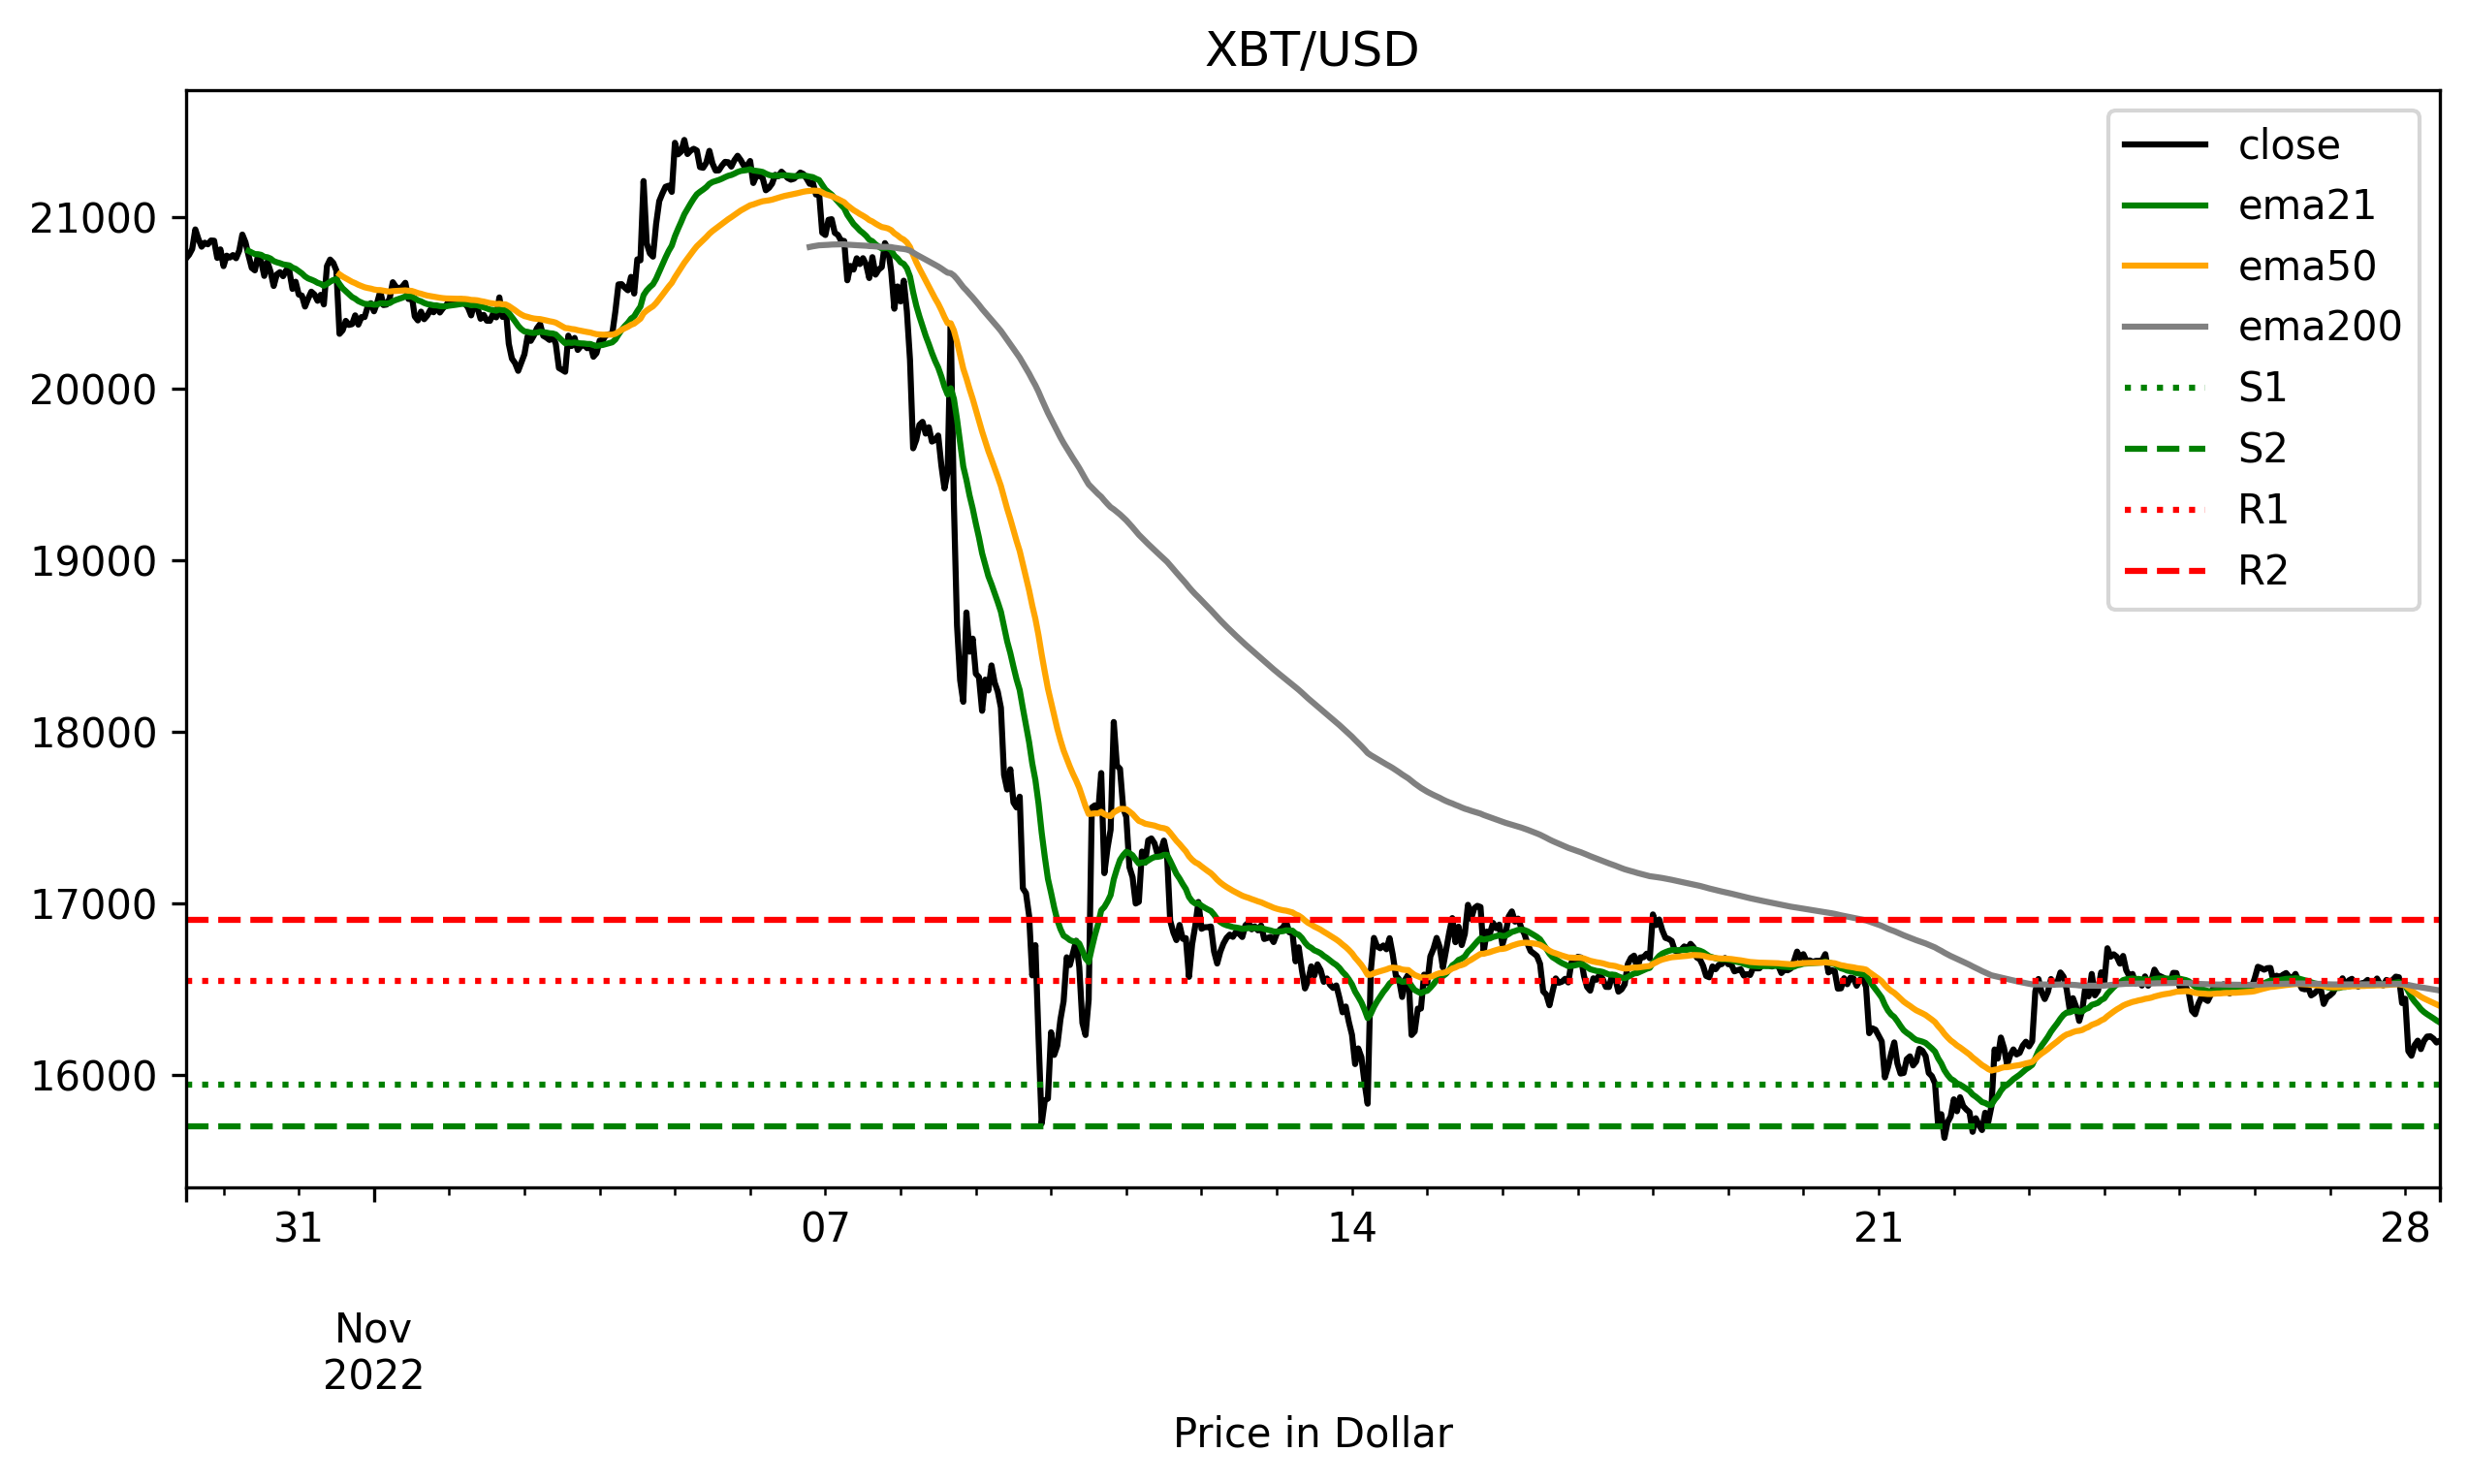

In [9]:
fig = plt.figure(figsize=(10,5), dpi=300)
ax = plt.gca()
df.plot(x='time', y=['close', 'ema21', 'ema50', 'ema200'], ax=ax, color=['black', 'green', 'orange', 'gray'])

xmin, xmax = df['time'].iloc[0], df['time'].iloc[-1]
ax.hlines(y=df['s1'].iloc[-1], xmin=xmin, xmax=xmax, color='green', linestyle=':', label='S1')
ax.hlines(y=df['s2'].iloc[-1], xmin=xmin, xmax=xmax, color='green', linestyle='--', label='S2')
ax.hlines(y=df['r1'].iloc[-1], xmin=xmin, xmax=xmax, color='red', linestyle=':', label='R1')
ax.hlines(y=df['r2'].iloc[-1], xmin=xmin, xmax=xmax, color='red', linestyle='--', label='R2')
ax.set_xlabel('Price in Dollar')
plt.legend()
plt.title('XBT/USD');

### Create and combine custom indicators, implement them, and build your own strategies ...